# About

- `Title:` "Supervised Learning with Quantum-Inspired Tensor Networks. arXiv e-prints, art"
- `Main Author:` Miles E. Stoudenmire
- `Source:` [ArXiv](https://arxiv.org/abs/1605.05775)
- `Publish Date:` 18-05-2017
- `Reviewed Date:` 22-10-2021

## Citation

```latex
@article{stoudenmire2016supervised,
  title={Supervised learning with tensor networks},
  author={Stoudenmire, Edwin and Schwab, David J},
  journal={Advances in Neural Information Processing Systems},
  volume={29},
  year={2016}
}
```

# Imports and settings

In [1]:
%matplotlib inline
%env JAX_ENABLE_X64=1
%env JAX_PLATFORM_NAME=cpu

env: JAX_ENABLE_X64=1
env: JAX_PLATFORM_NAME=cpu


In [2]:
import jax
import jax.numpy as jnp
from jax import jit, grad

In [3]:
import os
import pickle
import time
import itertools

from collections import defaultdict
from functools import reduce, partial
from itertools import accumulate

In [4]:
from typing import Any, List, DefaultDict,\
    Dict, Tuple, Callable, Optional, Iterable

In [5]:
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

## Types

In [6]:
# type alias
PRNGKeyArray = Any
DeviceArray = jnp.DeviceArray

# Constants

In [7]:
seed = 123     # random seed

bond_dim = 10  # the paper mentions 10, 20 and 120

α = 0.1      # learning rate

ϵ = 1e-1     # the allowed truncation error

# Helpers

In [8]:
def use_svg_display():
    """
    Use the svg format to display a plot in Jupyter.
    """
    matplotlib_inline.backend_inline.set_matplotlib_formats('svg')


def set_figsize(figsize=(3.5,2.5)):
    """
    Set the figure size for matplotlib.
    """
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize


def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """
    Set the axes for matplotlib.
    """
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()


def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5,2.5), axes=None,
         title=None):
    """
    Plot data points.
    """
    X = jnp.asarray(X)
    Y = jnp.asarray(Y)
    
    if legend is None:
        legend = []

    set_figsize(figsize)
    axes = axes if axes else plt.gca()

    # Return True if `X` (tensor or list) has 1 axis
    def has_one_axis(X):
        return (hasattr(X, "ndim") and X.ndim == 1 or
                isinstance(X, list) and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
    axes.set_title(title)

# Load data and visualise

In [9]:
import datasets

train_images, train_labels, test_images, test_labels = datasets.mnist()

In [10]:
print(f'Train data shape: {train_images.shape} | Test data shape: {test_images.shape}')

Train data shape: (60000, 784) | Test data shape: (10000, 784)


In [11]:
def show_img(img: jnp.ndarray, axes=None, title=None, figsize=(1.5,1.5)) -> None:
    """
    Shows a single image.
    """
    axes = axes if axes else plt.gca()
    set_figsize(figsize)
    axes.imshow(img, cmap='Greys')
    axes.set_xticks([])
    axes.set_yticks([])
    if title:
        axes.set_title(title, fontsize=9)


def show_img_grid(imgs: List[jnp.ndarray], titles: Iterable[str]) -> None:
    """
    Shows a grid of images.
    """
    n = int(jnp.ceil(len(imgs)**0.5))
    _, axes = plt.subplots(n,n)
    for i, (img, title) in enumerate(zip(imgs, titles)):
        show_img(img, axes[i // n][i % n], title)

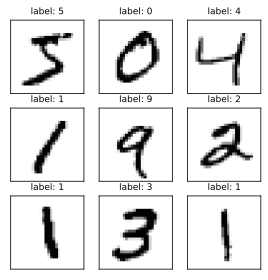

In [12]:
set_figsize((4.5,4.5))

show_img_grid(
    [train_images[i].reshape(28,28) for i in range(9)],
    [f"label: {jnp.argmax(train_labels[i])}" for i in range(9)]
)

# Downscaling images as in paper

In [13]:
def resize(img_vec: jnp.ndarray, shape: Tuple[int,int]) -> jnp.ndarray:
    """
    Resizing the image vector.
    """
    orig_size = jnp.sqrt(img_vec.size).astype(int)
    img = img_vec.reshape(orig_size, orig_size)
    img = jax.image.resize(img, shape, method='nearest')
    return img.reshape(-1)

In [14]:
new_shape = (14,14)

resize_vmap = partial(resize, shape=new_shape)

train_images_scaled = jax.vmap(resize_vmap)(train_images)
test_images_scaled = jax.vmap(resize_vmap)(test_images)

In [15]:
print(f'Train data shape: {train_images_scaled.shape} | Test data shape: {test_images_scaled.shape}')

Train data shape: (60000, 196) | Test data shape: (10000, 196)


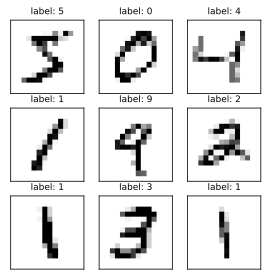

In [16]:
set_figsize((4.5,4.5))

show_img_grid(
    [train_images_scaled[i].reshape(new_shape) for i in range(9)],
    [f"label: {jnp.argmax(train_labels[i])}" for i in range(9)]
)

# Feature Map

In [17]:
def feature_map(x):
    """Definine a feature map per pixel"""
    return jnp.array([
        jnp.cos(0.5*jnp.pi*x), 
        jnp.sin(0.5*jnp.pi*x)
    ])

In [18]:
train_data = jax.vmap(feature_map)(train_images_scaled).transpose(0,2,1)  # exchanging axes for convenience
test_data = jax.vmap(feature_map)(test_images_scaled).transpose(0,2,1)    # same as above

In [19]:
print(f'Train data shape: {train_data.shape} | Test data shape: {test_data.shape}')

Train data shape: (60000, 196, 2) | Test data shape: (10000, 196, 2)


## MPS Utilities

In [20]:
# def random_mps(
#     key: PRNGKeyArray,
#     initializer: Callable, 
#     size: int,
#     local_dim: int,
#     bond_dim: int,
#     labels_dim: int,
#     dtype: Optional[jnp.double]=jnp.double
#     ) -> List[DeviceArray]:
#     """
#     Generate a random MPS where each core tensor
#     is drawn i.i.d. from a uniform distribution 
#     between 0 and 1.

#     Input:
#     ------
#     key:            The random key.
#     initializer:    The initializer (see jax.nn.initializers)
#     size:           The size (length) of an MPS.
#     local_dim:      The local dimension size.
#     bond_dim:       The bond dimension size.
#     labels_dim:     The dimension of labels.
#     dtype:          The type of data to return.
#     """
    
#     # initialize MPS tensor shapes
#     if size == 1:
#         shapes = [(1,local_dim,1, labels_dim)]
#     elif size == 2:
#         shapes = [(1,local_dim, bond_dim, labels_dim), (bond_dim, local_dim, 1)]
#     else:
#         shapes = [(1,local_dim, bond_dim, labels_dim)] +\
#                  [(bond_dim, local_dim, bond_dim)]*(size-2) +\
#                  [(bond_dim, local_dim, 1)] 

#     keys = jax.random.split(key, num=size)
#     return [initializer(*params) for params in zip(keys, shapes, [dtype]*size)]

In [24]:
def random_mps(
    key: PRNGKeyArray,
    size: int,
    local_dim: int,
    bond_dim: int,
    num_labels: int,
    dtype: Optional[jnp.double]=jnp.double
    ) -> List[DeviceArray]:
    """
    Generate a random MPS where each core tensor
    is drawn i.i.d. from a uniform distribution 
    between -1 and 1.

    Input:
    ------
    key:        The random key.
    size:       The size (length) of an MPS.
    local_dim:  The local dimension size.
    bond_dim:   The bond dimension size.
    dtype:      The type of data to return.
    """
    # initialize MPS data collection
    mps = []
     
    for i in range(size):
        key, _ = jax.random.split(key)
        if i == 0:  # left most tensor
            tensor = jax.random.uniform(
                key, shape=(1, local_dim, bond_dim, num_labels), minval=-1, maxval=1, dtype=dtype)
        elif i == size-1:  # right most tensor
            tensor = jax.random.uniform(
                key, shape=(bond_dim, local_dim, 1), minval=-1, maxval=1, dtype=dtype)
        else:  # middle tensors
            tensor = jax.random.uniform(
                key, shape=(bond_dim, local_dim, bond_dim), minval=-1, maxval=1, dtype=dtype)
        mps.append(tensor)

    return mps

In [32]:
key = jax.random.PRNGKey(seed)

# Spliting the key
key_params, key_run = jax.random.split(key, num=2)

# getting the parameters
num_samples, num_features, dim_features = train_data.shape
num_labels = train_labels.shape[1]

# mps weight initialiser
initializer = jax.nn.initializers.glorot_uniform()

# generating a random MPS according to the initialiser
mps = random_mps(key, num_features, dim_features, bond_dim, num_labels)
# mps = random_mps(key_params, initializer, num_features, dim_features, bond_dim, num_labels)

In [33]:
print(f'The MPS dimensions: size={num_features}, local_dim={dim_features}, bond_dim={bond_dim}')
print(f'Total number of paramters: {bond_dim**2 * dim_features * num_features}')

The MPS dimensions: size=196, local_dim=2, bond_dim=10
Total number of paramters: 39200


# Bond Truncation

In [34]:
@jax.jit
def suggest_truncation(
        λ: jnp.ndarray,
        ϵ: Optional[float]=1e-3  # truncation error proba
    ) -> Tuple[jnp.ndarray, jnp.ndarray, int]:
    """
    Suggest a truncation index j of the spectrum λᵢ i=1,⋅⋅⋅,N,
    such that the truncation error ϵ is an apper bound on the Σⱼ(1 - λⱼ/Σᵢλᵢ) ≤ ϵ.
    The spectrum is assumed to be in the decreasing order.
    """
    err = 1 - jnp.cumsum(λ / λ.sum())
    return jnp.searchsorted(err, p, side='right')

# Training

Precompute data to reduce complexity - see last paragraph on p.4 for more details. Note, as we start from the left most pair of sites, only the right part, i.e. the "right wings", are precomputed - hence starting from from the positin 2.

In [35]:
def project(mps, sample):
    """Project samples onto the mps sites."""
    mult = lambda tᵢ, xᵢ: jnp.einsum('piq,i->pq', tᵢ, xᵢ)
    return jax.tree_multimap(mult, mps, list(sample))

@jit
def compute_right_wings(mps, train_data):
    # get the projections of sample onto the mps sites
    # start with 2 as the first pair of indices are occupied by the bond tensor B
    right_projs = jax.vmap(partial(project, mps[2:]))(train_data[:,2:,:])
    # helper to contract neighbouring sites (watch the order in the lambda func!)
    mult = lambda x, y: jnp.einsum('mpi,miq->mpq', y, x)
    # get the cumulative products computed from left to right
    cum_prods = accumulate(right_projs[::-1], mult)
    # reverse before return so the indexing is natural again
    # unfortunately we can't access the iterator accumulate backwords
    return list(x.squeeze() for x in cum_prods)[::-1]

In [36]:
# a precomputed list of all right wings
# see last paragraph on p.4 for the motivation
right_wings = compute_right_wings(mps, train_data)

In [37]:
def cross_entropy(preds, targets):
    """Multinomial cross entropy"""
    return -jnp.mean(jnp.sum(preds * targets, axis=1))

def loss(B: DeviceArray, data: Tuple[DeviceArray, DeviceArray]):
    """A modified loss function"""
    inputs, targets = data
    preds = jnp.einsum('pijql,mpijq->ml', B, inputs)
    logprobas = jax.nn.log_softmax(preds, axis=1)
    return cross_entropy(logprobas, targets)

# def loss(B: DeviceArray, data: Tuple[DeviceArray, DeviceArray]):
#     """Loss function with respect to B - Fig.7a"""
#     inputs, targets = data
#     preds = jnp.einsum('pijql,mpijq->ml', B, inputs)
#     err = (targets - preds) ** 2
#     #return jnp.sqrt(0.5 * jnp.sum(err))
#     return 0.5 * jnp.mean(jnp.log(jnp.power(err, 2) + 1))

In [38]:
losses = []
N = len(mps)

max_bond = 5

for pos in range(N-1):

    # bond tensor - Fig.6a
    B = jnp.einsum('pjil,ikq->pjkql', mps[pos], mps[pos+1])

    # getting the new data inputs
    inputs = train_data[:,pos:pos+2]

    # projecting a input input into MPS basis - Fig.6b
    if pos == 0:
        right_wing = right_wings[pos]
        # because there is no left wing, insert a dummy index p instead
        inputs = jnp.expand_dims(inputs, axis=1)
        Φ = jnp.einsum('mpij,mq->mpijq', inputs, right_wing)
    elif pos == N-2:
        # because there is no right wing, insert a dummy index q instead
        inputs = jnp.expand_dims(inputs, axis=3)
        Φ = jnp.einsum('mp,mijq->mpijq', left_wing, inputs)
    else:
        right_wing = right_wings[pos]
        Φ = jnp.einsum('mp,mij,mq->mpijq', left_wing, inputs, right_wing)

    # compute the gradient update - Fig.6d
    ΔB = grad(loss)(B, data=(Φ, train_labels))

    # update the bond tensor - Fig.7a
    B += α * ΔB

    # SVD
    p,i,j,q,l = B.shape
    U, S, Vh = jnp.linalg.svd(B.reshape(p*i,-1), full_matrices=False)

    # cutting off the bond dimension
    if S.size > max_bond:
        U  = U[:,:max_bond]
        S  = S[:max_bond]
        Vh = Vh[:max_bond,:]

    # updating mps tesnors - Fig.7b
    mps[pos] = U.reshape(p,i,-1)  # current position
    mps[pos+1] = jnp.einsum('i,ij->ij', S, Vh).reshape(-1,j,q,l)  # next position

    # project input data onto current tensor
    proj_curr = jnp.asarray(
        jax.vmap(partial(project, [mps[pos]]))(train_data[:,[pos],:])
    ).squeeze()

    # update the left wing - Fig.7c
    if pos == 0:
        left_wing = proj_curr
    elif pos == N-2:
        pass
    else:
        left_wing = jnp.einsum('mp,mpq->mq', left_wing, proj_curr)

    losses.append(loss(B, data=(Φ, train_labels)))
    print(f'Updated site: {pos:<5}\t|\tLoss: {losses[-1]:<10.2e}\t|\tBond Dim: {bond_dim:<5}')

Updated site: 0    	|	Loss: 1.24e+95  	|	Bond Dim: 10   
Updated site: 1    	|	Loss: 8.75e+94  	|	Bond Dim: 10   
Updated site: 2    	|	Loss: 6.54e+94  	|	Bond Dim: 10   
Updated site: 3    	|	Loss: 1.35e+95  	|	Bond Dim: 10   
Updated site: 4    	|	Loss: 4.51e+94  	|	Bond Dim: 10   
Updated site: 5    	|	Loss: 5.22e+94  	|	Bond Dim: 10   
Updated site: 6    	|	Loss: 8.13e+94  	|	Bond Dim: 10   
Updated site: 7    	|	Loss: 1.59e+95  	|	Bond Dim: 10   
Updated site: 8    	|	Loss: 1.36e+95  	|	Bond Dim: 10   
Updated site: 9    	|	Loss: 1.63e+95  	|	Bond Dim: 10   
Updated site: 10   	|	Loss: 5.50e+94  	|	Bond Dim: 10   
Updated site: 11   	|	Loss: 2.42e+94  	|	Bond Dim: 10   
Updated site: 12   	|	Loss: 2.04e+94  	|	Bond Dim: 10   
Updated site: 13   	|	Loss: 2.52e+94  	|	Bond Dim: 10   
Updated site: 14   	|	Loss: 9.64e+93  	|	Bond Dim: 10   
Updated site: 15   	|	Loss: 5.23e+94  	|	Bond Dim: 10   
Updated site: 16   	|	Loss: 1.56e+94  	|	Bond Dim: 10   
Updated site: 17   	|	Loss: 1.5

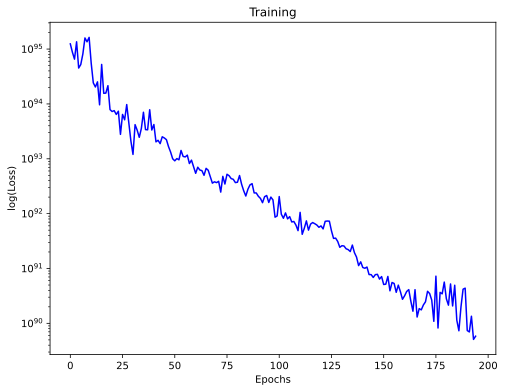

In [40]:
set_figsize((8,6))
plt.plot(losses, 'b-')
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('log(Loss)')
plt.title('Training')
plt.show()